In [83]:
import pandas as pd
from PIL import Image
import requests
from tqdm._tqdm_notebook import tqdm_notebook

C:\Users\JselZ\AppData\Local\Temp\ipykernel_12552\2720405391.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
tab1=pd.read_csv("tab1.csv")
tab2=pd.read_csv("tab2.csv")
tab1.head(3)

,ID #,reportType,photo_date,photo_time,from_device,AuthorName,AuthorEmail,URL,images,location_longitude,...,response_other,road_damage_detail,marinas_damage_detail,beach_damage_detail,buildings_damage_detail,hazmat_damage_detail,response_damage,amazonS3_cache,place_name,structure_damage_detail
0,161872,Flood Watch,2024-04-12,11:56 am,iOS 17.4.1,NaN,NaN,https://mycoast.org/reports/161872,https://report-images.nyc3.digitaloceanspaces....,-73.769758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,161869,Flood Watch,2024-04-12,11:40 am,iOS 15.8.2,NaN,NaN,https://mycoast.org/reports/161869,https://report-images.nyc3.digitaloceanspaces....,-73.832707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,161865,Flood Watch,2024-04-12,11:37 am,iOS 15.8.2,NaN,NaN,https://mycoast.org/reports/161865,https://report-images.nyc3.digitaloceanspaces....,-73.832843,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
tab2.head(3)

,ID #,reportType,photo_date,photo_time,from_device,AuthorName,AuthorEmail,URL,images,location_longitude,...,buildings_damage,buildings_street,buildings_comments,hazmat_damage damage-cat,hazmat_comments,beach_damage,beach_comments,structure_damage,structures_comments,response_other
0,138454,Flood Watch,2019-11-13,04:00 pm,Can reports - Survey123,NaN,NaN,https://mycoast.org/reports/138454,https://report-images.nyc3.digitaloceanspaces....,-73.788356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,135304,Flood Watch,2019-11-13,08:17 am,Can reports - Airtable,NaN,NaN,https://mycoast.org/reports/135304,https://report-images.nyc3.digitaloceanspaces....,-73.788356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,139786,Flood Watch,2019-10-31,04:00 pm,Can reports - Survey123,NaN,NaN,https://mycoast.org/reports/139786,https://report-images.nyc3.digitaloceanspaces....,-73.830065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
comm_cols=list(set(tab1.columns).intersection(set(tab2.columns))) # get common fields
tab1=tab1[comm_cols] # select common fields
tab2=tab2[comm_cols] # select common fields
df=pd.concat([tab1,tab2]).reset_index() # concat (vertically), reset index to be count
df[["ID #"]] # check

,ID #
0,161872
1,161869
2,161865
3,161715
4,161698
...,...
1784,113708
1785,143134
1786,143141
1787,143127


In [ ]:
df.loc[0,"images"]

- `image` column contains url separated by `|`

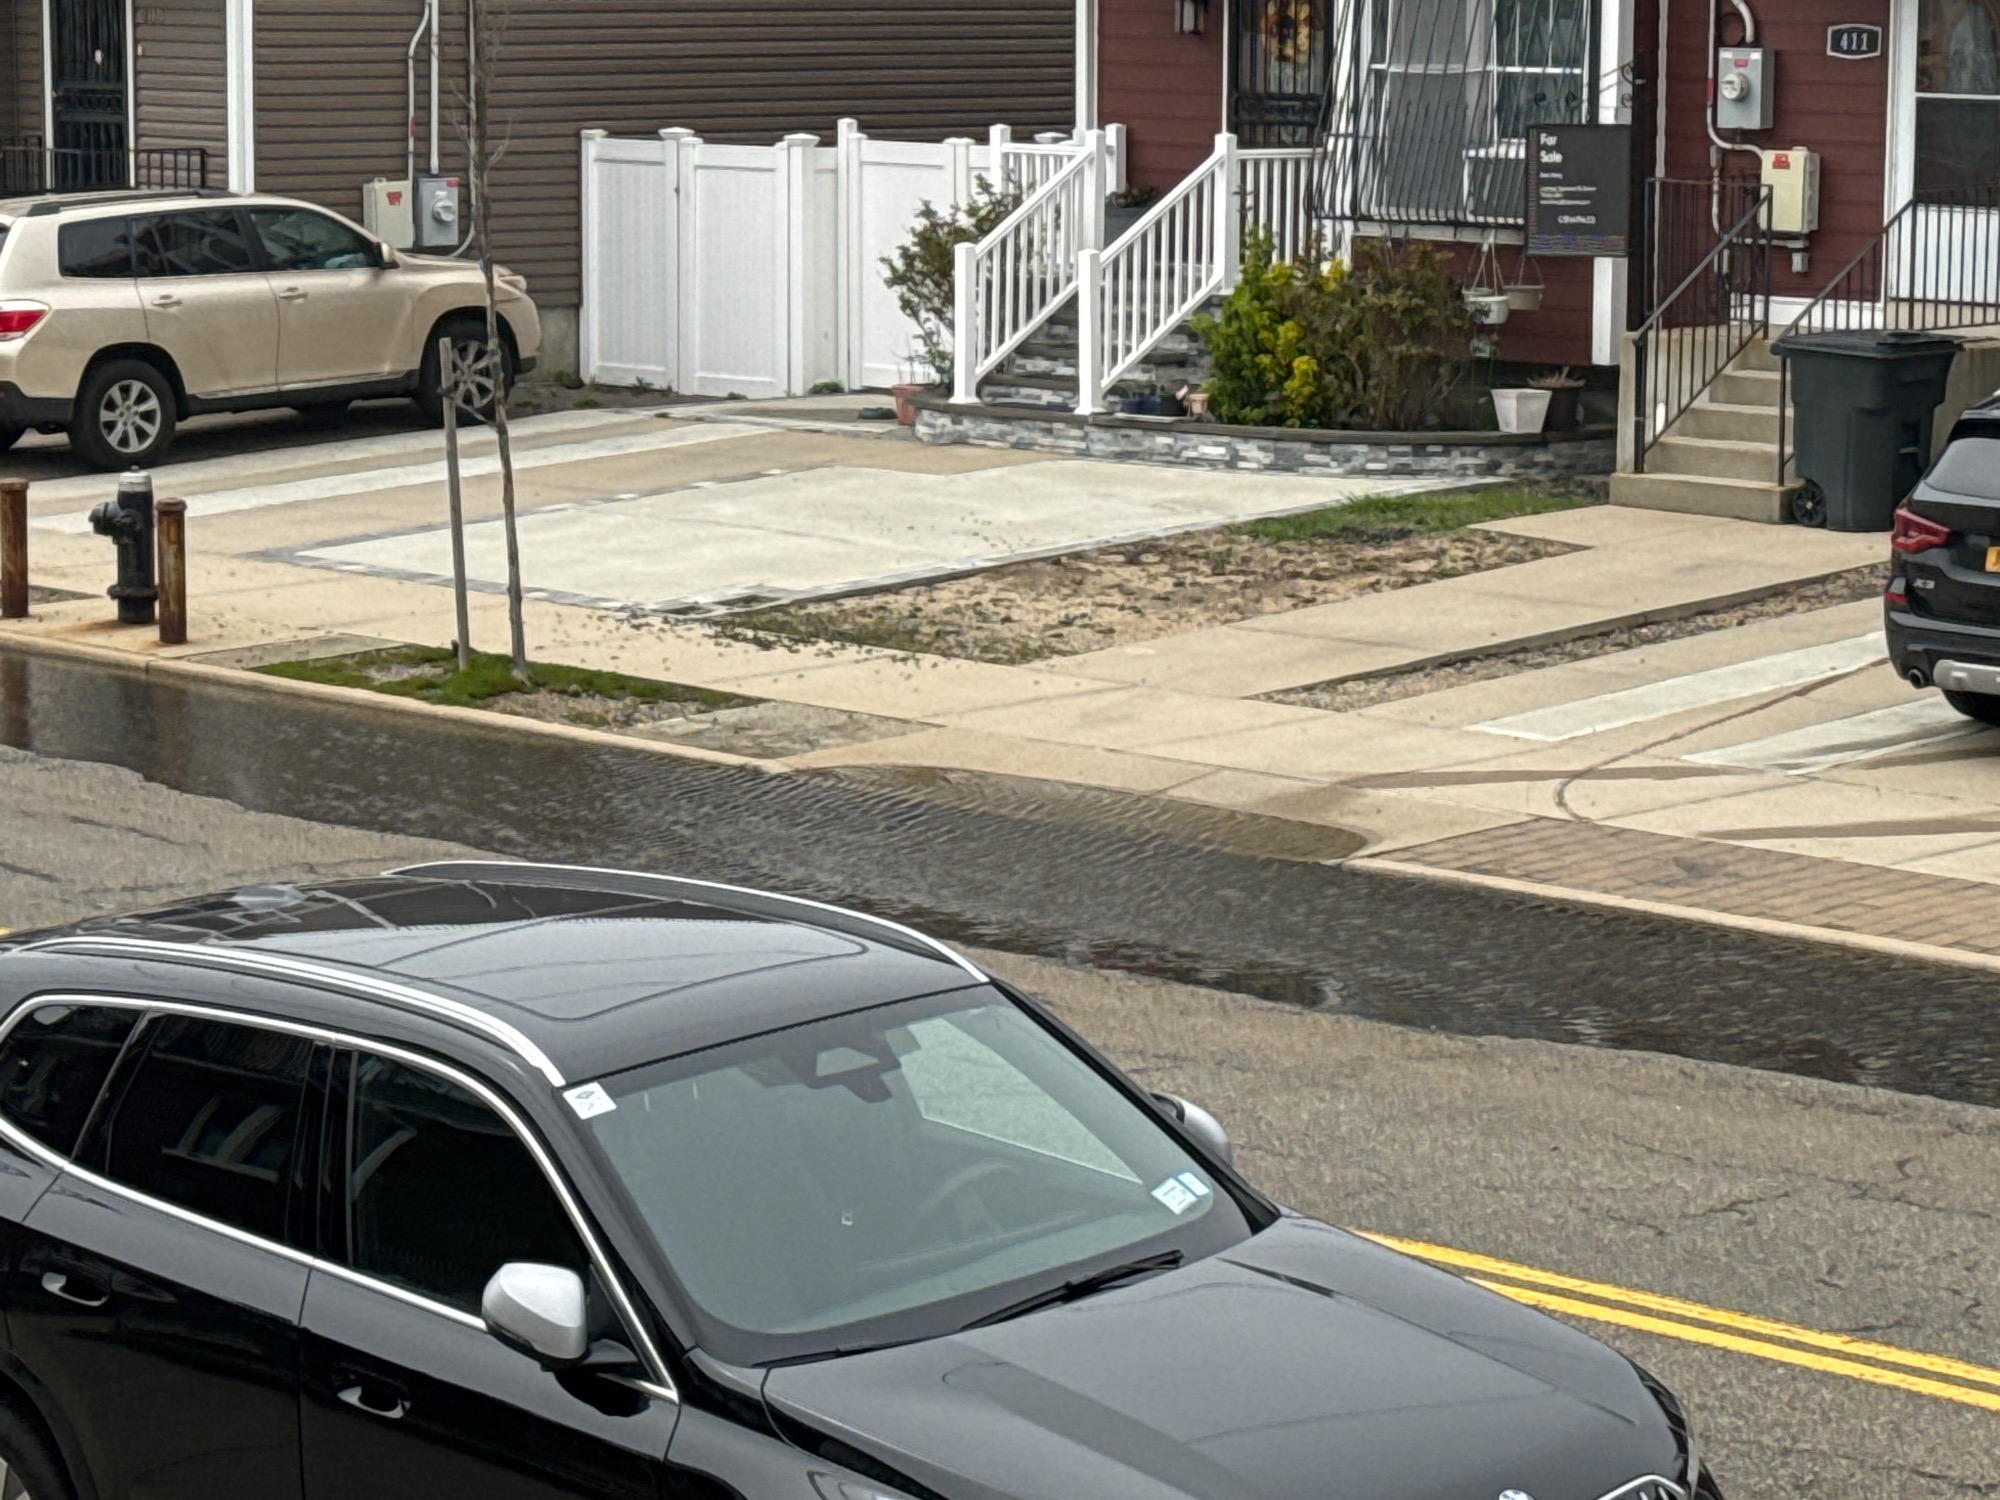

In [17]:
import IPython
IPython.display.Image(df.loc[0,"images"].split("|")[0], width=300)

# --if cant be used, another way: 
# im = Image.open(requests.get(df.loc[0,"images"].split("|")[0], stream=True).raw)
# im.thumbnail(size=[300,300])
# im

## 1. brightness check to confirm time

In [69]:
img=Image.open(requests.get(df.loc[0,"images"].split("|")[0], stream=True).raw)
img_gray=img.convert("L")
sum(img_gray.getdata()) / len(img_gray.getdata())

122.50348966666667

In [60]:
def get_avg_br(img_str:str):
    '''
    takes in a string of image URIs separated by '|' and outputs the relative brightness of the images in the string
    '''
    # make sure you import `time` package

    if type(img_str)!=str or len(img_str)==0: # order matters, or error
        return None
    br_sum=[]
    img_list=img_str.split("|")
    # --The following is to handle the possible http429 problem (set sleep):
    # try:
    #     for imgurl in img_list:
    #         img=Image.open(requests.get(imgurl, stream=True).raw)
    #         img_gray=img.convert("L")
    #         br_sum.append(sum(img_gray.getdata()) / len(img_gray.getdata()))
    # except:
    #     time.sleep(2)
    #     for imgurl in img_list:
    #         img=Image.open(requests.get(imgurl, stream=True).raw)
    #         img_gray=img.convert("L")
    #         br_sum.append(sum(img_gray.getdata()) / len(img_gray.getdata()))

    for imgurl in img_list:
            img=Image.open(requests.get(imgurl, stream=True).raw)
            img_gray=img.convert("L")
            br_sum.append(sum(img_gray.getdata()) / len(img_gray.getdata()))
    return round(sum(br_sum)/len(br_sum),2)

In [82]:
print(f'ID: {df.loc[0,"ID #"]}\nTime: {df.loc[0,"photo_date"]+" "+df.loc[0,"photo_time"]}\nAverage Brightness: {get_avg_br(df.loc[0,"images"])}')

ID: 161872
Time: 2024-04-12 11:56 am
Average Brightness: 128.54


In [15]:
# Before apply to all rows, check brightness at night time: 
df[df["photo_time"].str.endswith("pm")].head(3)

,index,flooded-other,guessDepth,AuthorEmail,structure_damage,float_number,geo_locality,beach_damage,photo_time,marinas_comments,...,alternate-location-name,boat_number,weather_temperature,photo_date,location_longitude,TideDataPredicted,beach_comments,marinas_damage,geo_administrative_area_level_2,hazmat_comments
5,5,NaN,0,NaN,NaN,NaN,NaN,NaN,11:37 pm,NaN,...,NaN,NaN,54.9,2024-04-11,-73.832696,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN
6,6,NaN,10,NaN,NaN,NaN,NaN,NaN,11:13 pm,NaN,...,NaN,NaN,56.6,2024-04-11,-73.831856,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN
8,8,NaN,0,NaN,NaN,NaN,NaN,NaN,9:42 pm,NaN,...,NaN,NaN,52.1,2024-04-09,-73.832824,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN


48.11


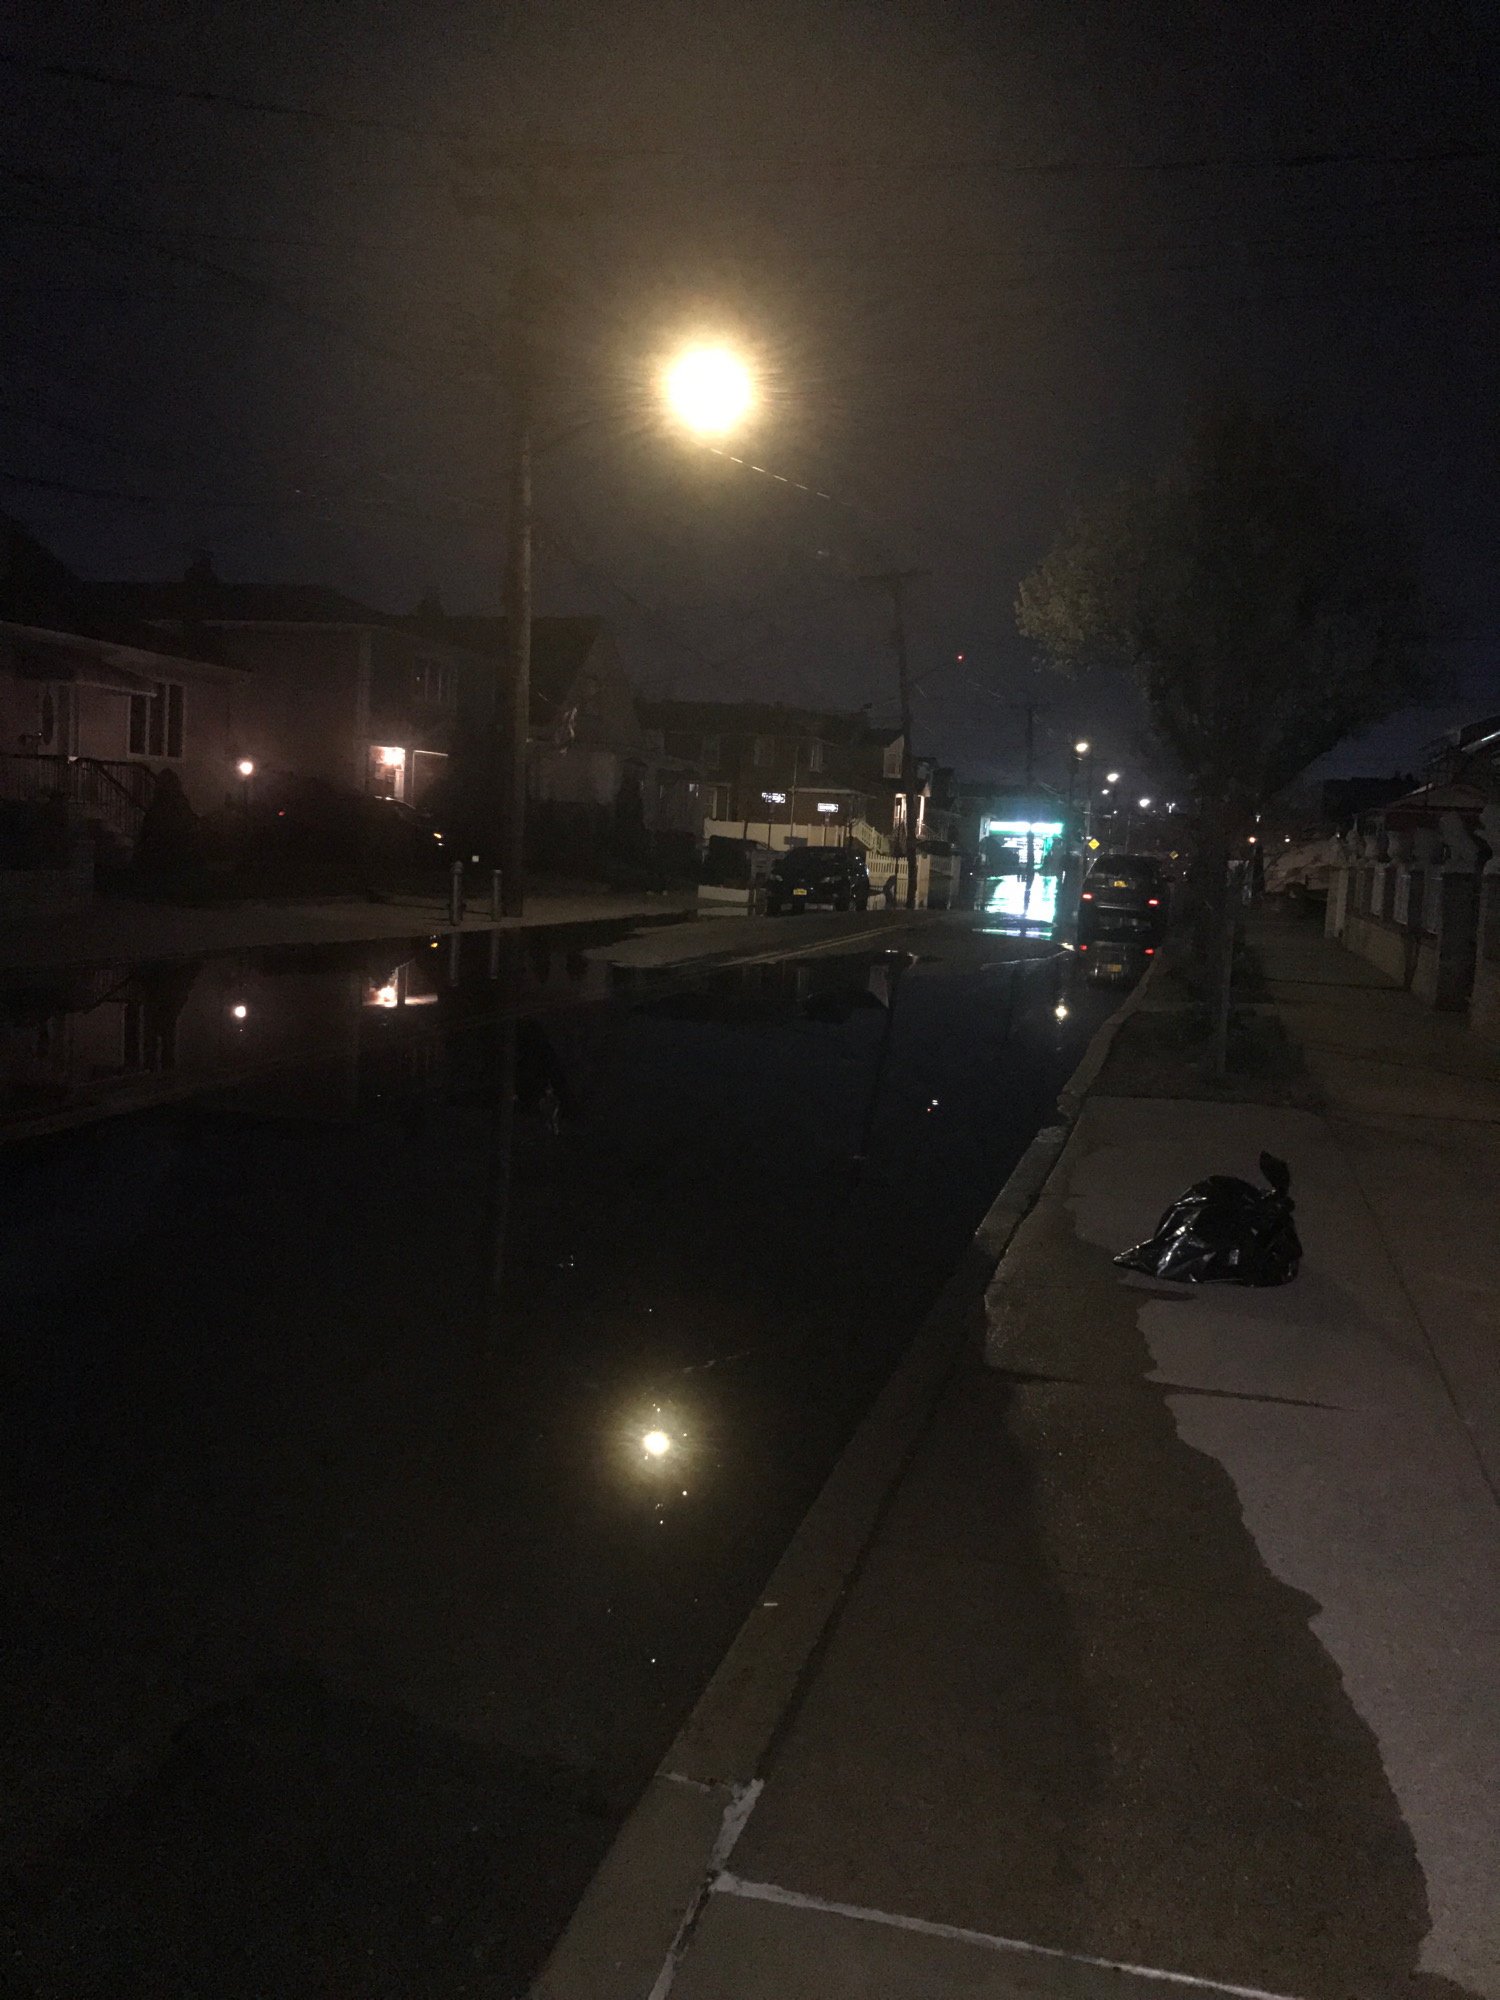

In [41]:
# choose idx=8
print(get_avg_br(df.loc[8,"images"]))
# very low, corresponds to night)
IPython.display.Image(df.loc[8,"images"].split("|")[0], width=300)

In [31]:
# check evening time to roughly set threshold 
df[(df["photo_time"].str.endswith("pm"))&(df["photo_time"].str.startswith("8"))].head(10)

,index,flooded-other,guessDepth,AuthorEmail,structure_damage,float_number,geo_locality,beach_damage,photo_time,marinas_comments,...,alternate-location-name,boat_number,weather_temperature,photo_date,location_longitude,TideDataPredicted,beach_comments,marinas_damage,geo_administrative_area_level_2,hazmat_comments
13,13,NaN,3,NaN,NaN,NaN,NaN,NaN,8:04 pm,NaN,...,Far Rockaway,NaN,50.8,2024-04-08,-73.769775,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN
73,73,NaN,NaN,NaN,No Impacts,0.0,NaN,Accessible,8:33 pm,NaN,...,NaN,0.0,47.9,2024-03-09,-73.832805,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,No Impacts,Queens County,NaN
91,91,NaN,NaN,NaN,No Impacts,0.0,Mamaroneck,Accessible,8:14 pm,NaN,...,Columbus Park,0.0,49.7,2024-03-02,-73.737117,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,No Impacts,Westchester County,NaN
356,356,NaN,15,NaN,NaN,NaN,NaN,NaN,8:32 pm,NaN,...,NaN,NaN,58.9,2023-06-03,-73.830773,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN
399,399,NaN,NaN,NaN,No Impacts,0.0,NaN,Accessible,8:30 pm,NaN,...,NaN,0.0,11.6,2022-12-23,-73.841937,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,No Impacts,Queens County,NaN


74.76


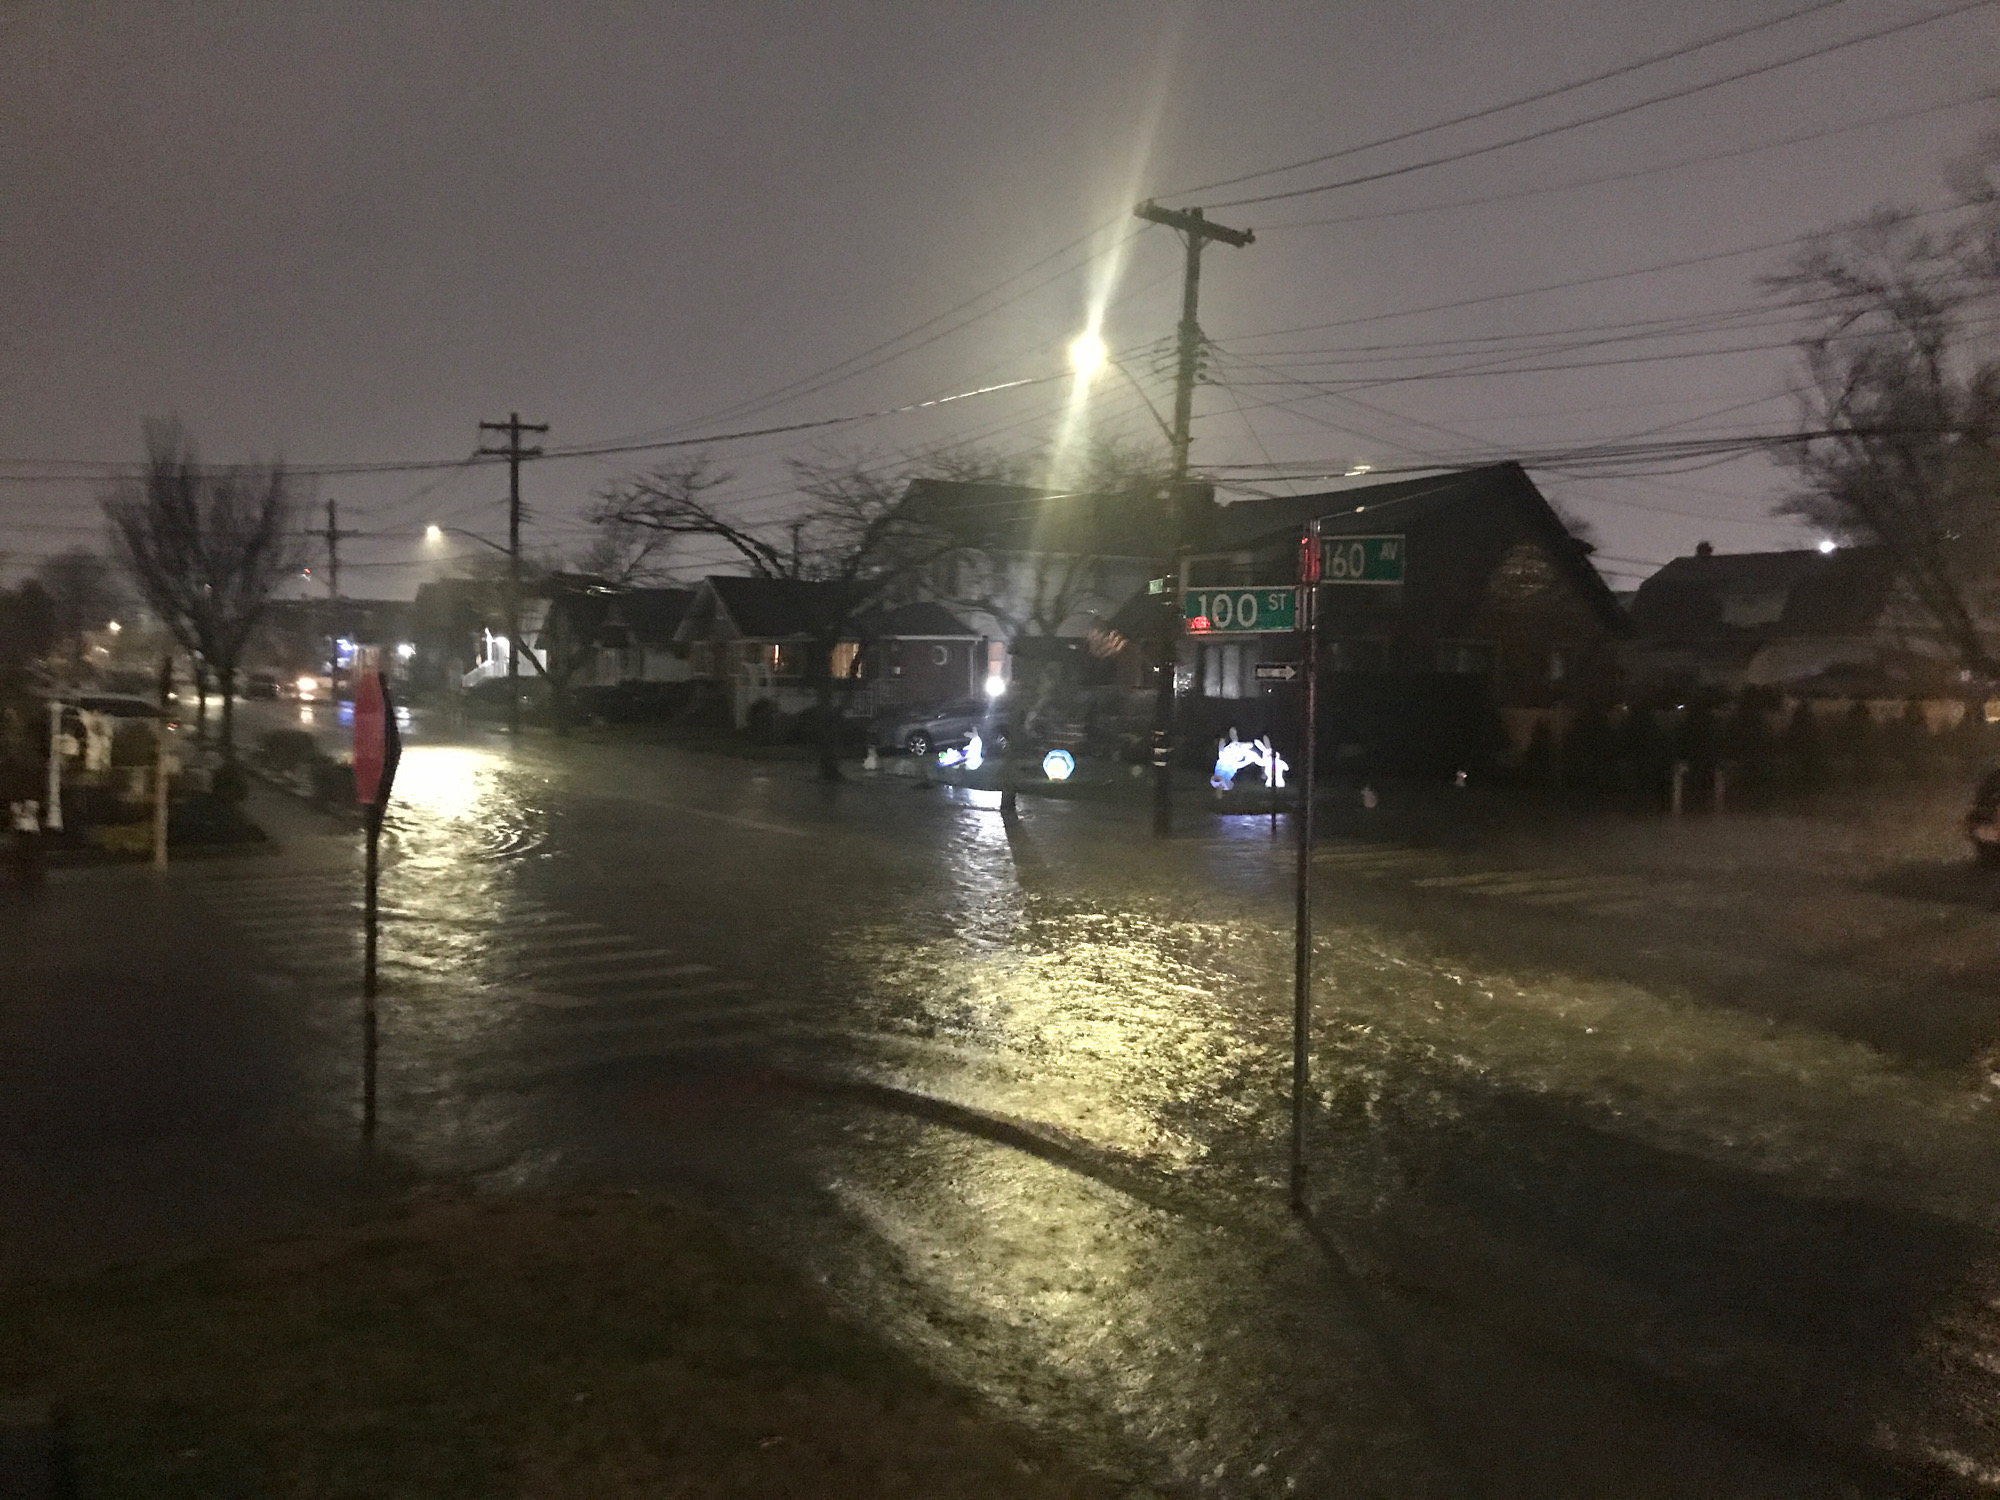

In [39]:
print(get_avg_br(df.loc[73,"images"]))
IPython.display.Image(df.loc[73,"images"].split("|")[0], width=300)

In [61]:
# add a process bar for this big task: -- not working, commented:
# tqdm.pandas(desc="Calculating brightness")
# df['brightness'] = tqdm(df['images']).progress_apply(get_avg_br)
df['brightness']=df["images"].apply(get_avg_br)

In [74]:
# self-defined time conversion func., has problems, not using:
def to24hr(tstr:str):
    if tstr.endswith("pm"):
        tstr=str(int(tstr.split(":")[0])+12)+":"+tstr.split(":")[1]
    return tstr[:-3]

In [86]:
df['photo_time'] = pd.to_datetime(df['photo_time']).dt.strftime("%H:%M")

In [88]:
df.head(3)

,index,flooded-other,guessDepth,AuthorEmail,structure_damage,float_number,geo_locality,beach_damage,photo_time,marinas_comments,...,boat_number,weather_temperature,photo_date,location_longitude,TideDataPredicted,beach_comments,marinas_damage,geo_administrative_area_level_2,hazmat_comments,brightness
0,0,NaN,2,NaN,NaN,NaN,NaN,NaN,11:56,NaN,...,NaN,54.1,2024-04-12,-73.769758,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,128.54
1,1,NaN,0,NaN,NaN,NaN,NaN,NaN,11:40,NaN,...,NaN,54.9,2024-04-12,-73.832707,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,156.08
2,2,NaN,0,NaN,NaN,NaN,NaN,NaN,11:37,NaN,...,NaN,54.9,2024-04-12,-73.832843,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,148.64


In [89]:
df.to_csv("df.csv")

In [98]:
df[(pd.to_numeric(df["photo_time"].str[:2], errors='coerce') > 9) & 
   (pd.to_numeric(df["photo_time"].str[:2], errors='coerce') < 17)&
   (df["brightness"]<70)]

,index,flooded-other,guessDepth,AuthorEmail,structure_damage,float_number,geo_locality,beach_damage,photo_time,marinas_comments,...,boat_number,weather_temperature,photo_date,location_longitude,TideDataPredicted,beach_comments,marinas_damage,geo_administrative_area_level_2,hazmat_comments,brightness
990,990,NaN,2,NaN,NaN,NaN,NaN,NaN,12:27,NaN,...,NaN,75.3,2020-07-11,-73.801823,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Bronx County,NaN,61.88
997,997,NaN,4,NaN,NaN,NaN,NaN,NaN,12:27,NaN,...,NaN,66.5,2020-05-30,-73.801915,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Bronx County,NaN,50.97
1022,1022,NaN,12-24,NaN,NaN,NaN,NaN,NaN,12:59,NaN,...,NaN,45.6,2020-05-07,-73.837150,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,39.27
1025,1025,NaN,6-12,NaN,NaN,NaN,NaN,NaN,12:49,NaN,...,NaN,45.4,2020-05-07,-73.817703,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,46.61
1028,1028,NaN,1-6,NaN,NaN,NaN,NaN,NaN,12:30,NaN,...,NaN,45.5,2020-05-07,-73.829534,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,22.80
1031,1031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:00,NaN,...,NaN,46.3,2020-05-07,-73.817082,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,18.84
1032,1032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:00,NaN,...,NaN,46.3,2020-05-07,-73.829534,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,22.78
1035,1035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:00,NaN,...,NaN,46.3,2020-05-07,-73.817703,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,46.61
1036,1036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:00,NaN,...,NaN,46.3,2020-05-07,-73.837150,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,39.27
1037,1037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:00,NaN,...,NaN,46.3,2020-05-07,-73.817029,https://tidesandcurrents.noaa.gov/noaatidepred...,NaN,NaN,Queens County,NaN,42.10


In [94]:
def showimginfo(iloc:int):
    print(get_avg_br(df.loc[iloc,"images"]))
    IPython.display.Image(df.loc[iloc,"images"].split("|")[0], width=300)

39.27


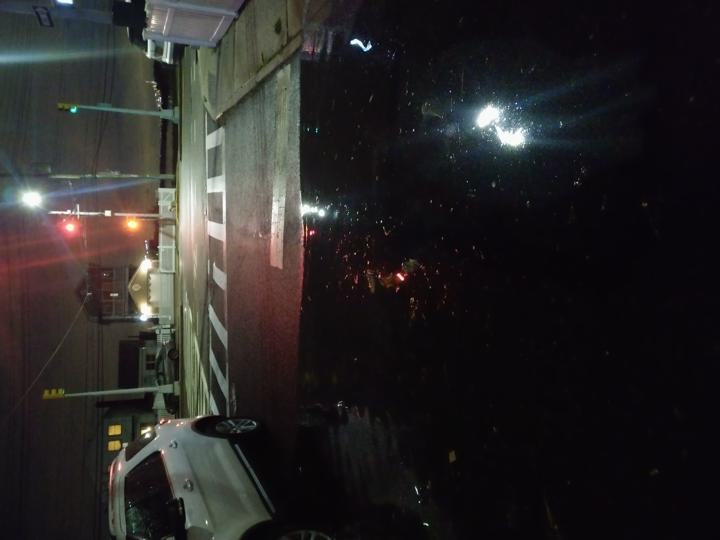

In [100]:
print(get_avg_br(df.loc[1022,"images"]))
IPython.display.Image(df.loc[1022,"images"].split("|")[0], width=300)

52.06


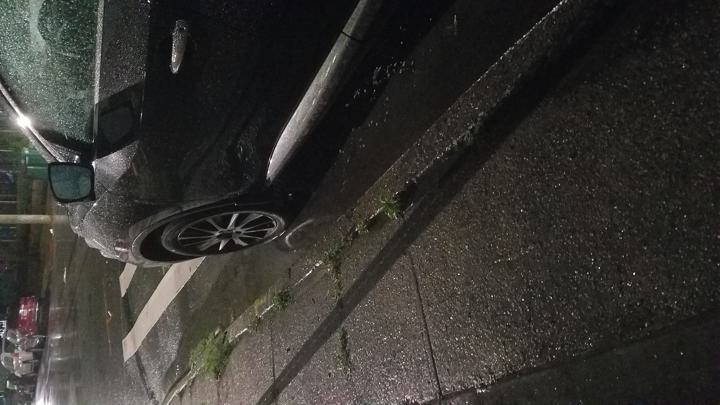

In [97]:
print(get_avg_br(df.loc[353,"images"]))
IPython.display.Image(df.loc[353,"images"].split("|")[0], width=300)

## 2.